In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import yfinance as yf
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [2]:
df=yf.download(tickers='EURUSD=X',start='2010-01-01',end='2019-12-31',interval ='1d')
df = df.filter(['Close'])
dataset = df.values
train_len = math.ceil( len(dataset) *.9) 
scaler = MinMaxScaler(feature_range = (0, 1))
training_data = scaler.fit_transform(dataset[:train_len , : ]) 
x_train =[] 
y_train =[] 

for i in range(60, len(training_data)):
    x_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])
    
x_train,y_train = np.array(x_train), np.array(y_train)
x_train= np.reshape(x_train,( x_train.shape[0] ,x_train.shape[1] ,1))

[*********************100%***********************]  1 of 1 completed


In [3]:
test_data = scaler.transform(dataset[train_len - 60: , : ])
x_test = []
y_test = []

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [4]:
forexPredictor = Sequential()
forexPredictor.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
forexPredictor.add(Dropout(0.2))
forexPredictor.add(LSTM( 50, return_sequences = False))
forexPredictor.add(Dropout(0.2))
forexPredictor.add(Dense(50))
forexPredictor.add(Dense(1))
forexPredictor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [5]:
forexPredictor.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
72/72 [==============================] - 7s 41ms/step - loss: 0.0447
Epoch 2/100
72/72 [==============================] - 3s 36ms/step - loss: 0.0035
Epoch 3/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0030
Epoch 4/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0026
Epoch 5/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0024
Epoch 6/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0021
Epoch 7/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0021
Epoch 8/100
72/72 [==============================] - 3s 35ms/step - loss: 0.0020
Epoch 9/100
72/72 [==============================] - 2s 34ms/step - loss: 0.0020
Epoch 10/100
72/72 [==============================] - 2s 34ms/step - loss: 0.0016
Epoch 11/100
72/72 [==============================] - 2s 34ms/step - loss: 0.0016
Epoch 12/100
72/72 [==============================] - 3s 36ms/step - loss: 0.0015
Epoch 13/100
72/72 [=====

In [6]:
test_predictions = forexPredictor.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions) 


rmse = np.sqrt(np.mean(((test_predictions - y_test) ** 2)))
print(rmse)
    


0.9361749664210938


In [7]:
end_date = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=84)).strftime('%Y-%m-%d')
user_df = yf.download(tickers='EURUSD=X', start=start_date, end=end_date, interval='1d')
user_df = user_df.filter(['Close'])
user_data_value = user_df.values
user_data = scaler.transform(user_data_value)
forex_input = []
for i in range(60, len(user_data)):
    forex_input.append(user_data[i - 60:i, 0])
temp_input = list(forex_input)
temp_input = temp_input[0].tolist()
forex_input = np.array(forex_input)
forex_input = np.reshape(forex_input, (forex_input.shape[0], forex_input.shape[1], 1))



forex_output = []
n_steps = 60
i = 0

while i < 5:

        if (len(temp_input) > n_steps):
            forex_input = np.array(temp_input[1:])
            forex_input = forex_input.reshape(1, -1)
            forex_input = forex_input.reshape((1, n_steps, 1))
            pred_value = forexPredictor.predict(forex_input)
            temp_input.extend(pred_value[0].tolist())
            temp_input = temp_input[1:]
            forex_output.extend(pred_value.tolist())
            i = i + 1
        else:
            forex_input = forex_input.reshape((1, n_steps, 1))
            pred_value = forexPredictor.predict(forex_input)
            temp_input.extend(pred_value[0].tolist())
            forex_output.extend(pred_value.tolist())
            i = i + 1

predictions = scaler.inverse_transform(forex_output)


print(predictions)

[*********************100%***********************]  1 of 1 completed
[[1.21926014]
 [1.2191133 ]
 [1.21867936]
 [1.21822254]
 [1.21773619]]


Text(0, 0.5, 'Close Price USD ($)')

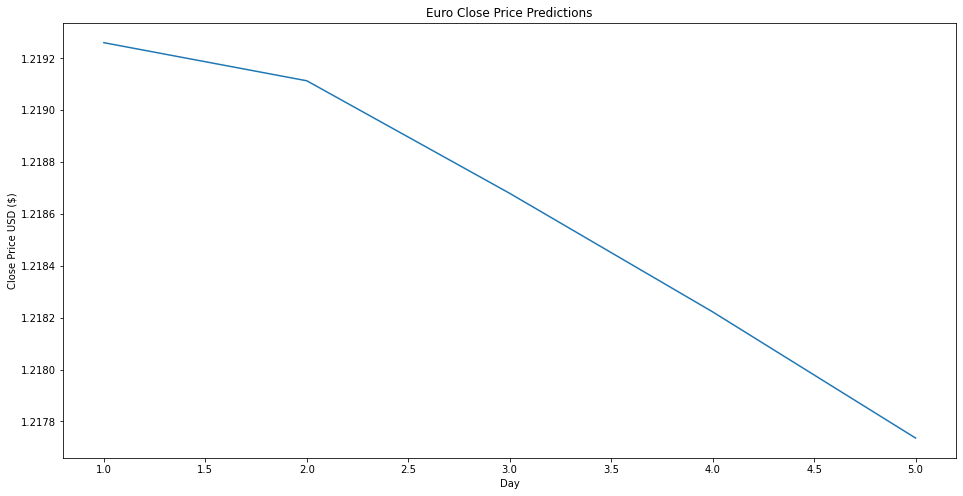

In [8]:





days = np.arange(1, 6)

plt.figure(figsize=(16, 8))
plt.title('Euro Close Price Predictions')
plt.plot(days, predictions)

plt.xlabel('Day', fontsize=10)
plt.ylabel('Close Price USD ($)', fontsize=10)

In [9]:
from numpy import newaxis

In [10]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


def plot_results_multiple(predicted_data, true_data, prediction_len):
    plt.figure(figsize=(50, 20))
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.show()



<Figure size 3600x1440 with 0 Axes>

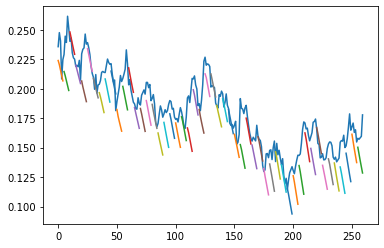

In [11]:
predictions = predict_sequences_multiple(forexPredictor, x_test, 60, 5)

plot_results_multiple(predictions, y_test, 5)
